In [1]:
#Basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from glob import glob
#Glob in dataframes
source = 'competition_data'
data ={}
for path in glob(os.path.join(source, '*.csv')):
    df = pd.read_csv(path)
    filename = path.split('\\')[-1]
    filename = filename.split('.')[0]
    data[filename] = df

#Check our work
data.keys()

dict_keys(['bill_of_materials', 'components', 'comp_adaptor', 'comp_boss', 'comp_elbow', 'comp_float', 'comp_hfl', 'comp_nut', 'comp_other', 'comp_sleeve', 'comp_straight', 'comp_tee', 'comp_threaded', 'specs', 'test_set', 'train_set', 'tube', 'tube_end_form', 'type_component', 'type_connection', 'type_end_form'])

In [3]:
#Declare a few specific frames to start working on features
materials = data['bill_of_materials']
components = data['components']
tube = data['tube']
trainval = data['train_set']
test = data['test_set']

In [4]:
materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Get a tidy version of materials by tube_assembly_id and component_ids
assembly_components = materials.melt(id_vars = 'tube_assembly_id',
                                     value_vars = [f'component_id_{n}' for n in range(1,9)])
#Sort value by tube_assembly_id, drop na values, and rename value to component_id for clarity
assembly_components = (assembly_components
                       .sort_values(by='tube_assembly_id')
                       .dropna()
                       .rename(columns = {'value':"component_id"}))
#Have a look
assembly_components.head()

,tube_assembly_id,variable,component_id
0,TA-00001,component_id_1,C-1622
21198,TA-00001,component_id_2,C-1629
1,TA-00002,component_id_1,C-1312
2,TA-00003,component_id_1,C-1312
3,TA-00004,component_id_1,C-1312


In [8]:
#Merge with component_types
assembly_component_types =  assembly_components.merge(components, how = 'left')
assembly_component_types.head()

,tube_assembly_id,variable,component_id,name,component_type_id
0,TA-00001,component_id_1,C-1622,NUT-SWIVEL,CP-025
1,TA-00001,component_id_2,C-1629,SLEEVE-ORFS,CP-024
2,TA-00002,component_id_1,C-1312,NUT-FLARED,CP-028
3,TA-00003,component_id_1,C-1312,NUT-FLARED,CP-028
4,TA-00004,component_id_1,C-1312,NUT-FLARED,CP-028


In [18]:
#Make a crosstab out of assembly_component_types
table = pd.crosstab(assembly_component_types['tube_assembly_id'],
                    assembly_component_types['component_type_id'])
table = table.reset_index()
table.columns.name = ''
print(table.shape)
table.head()

(19149, 30)


,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,...,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [10]:
#Find components that share 'weight' feature
#Create a search function for later use

def search_column(name):
    for path in glob(os.path.join(source, '*.csv')):
        df = pd.read_csv(path)
        if name in df.columns:
            print(path,df.shape)
            print(df.columns.tolist(), '\n')

In [14]:
#Read all component dataframes and concatenate them into one df
df_list = [pd.read_csv(path) for path in glob(os.path.join(source, 'comp_*.csv'))]
comp = pd.concat(df_list, sort=False)
#Focus in on the shared features
columns = ['component_id', 'component_type_id', 'weight', 'unique_feature', 'orientation']
comp = comp[columns]
#Convert binarys to numeric values
comp['unique_feature'] = (comp['unique_feature']=='Yes').astype(int)
comp['orientation'] = (comp['orientation']=='Yes').astype(int)
#Fill weight nas with median
comp['weight'] = comp['weight'].fillna(comp['weight'].median())
del df_list

In [15]:
#Create features for total components and number of distinct components
materials['components_total'] = sum(materials[f'quantity_{n}'].fillna(0) for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}']
                                                 .notnull()
                                                 .astype(int) for n in range(1,9))
#Create matching columns in materials
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

for n in range(1,9):
    materials = materials.merge(comp, left_on = f'component_id_{n}',
                                right_on = 'component_id', how = 'left',
                                suffixes = ('', f'_{n}'))
    
for col in materials:
    if 'orientation' in col or 'weight' in col or 'unique_feature' in col:
        materials[col] = materials[col].fillna(0)
        
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1,9))

In [16]:
#Reduce number of features to a more manageable set
features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight', 
            'components_total', 'components_distinct', 'component_id_1']
materials = materials[features]

In [20]:
#Split trainval data by tube assembly id
from sklearn.model_selection import train_test_split

trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(trainval_tube_assemblies, random_state = 42)

train = trainval[trainval['tube_assembly_id'].isin(train_tube_assemblies)]
val = trainval[trainval['tube_assembly_id'].isin(val_tube_assemblies)]

#Wranlge the train, validation, and testing data
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge data
    X = (X.merge(table, how='left')
         .merge(materials, how='left')
         .merge(tube, how='left')
         .fillna(0))
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    return X

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [22]:
#Arrange X and y features/target matrices, log transformed
target = 'cost'
X_train = train_wrangled.drop(columns = target)
X_val = val_wrangled.drop(columns = target)
X_test = test_wrangled.drop(columns = 'id')

y_train = train_wrangled[target]
y_val = val_wrangled[target]

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [24]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/5e/49/b95c037b717b4ceadc76b6e164603471225c27052d1611d5a2e832757945/xgboost-0.90-py2.py3-none-win_amd64.whl


In [25]:
import category_encoders as ce
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
model = XGBRegressor

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]

model = XGBRegressor(n_estimators=2000, verbosity=0, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[0]	validation_0-rmse:1.71937	validation_1-rmse:1.70792
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.565	validation_1-rmse:1.55417
[2]	validation_0-rmse:1.42839	validation_1-rmse:1.41869
[3]	validation_0-rmse:1.30405	validation_1-rmse:1.29476
[4]	validation_0-rmse:1.19196	validation_1-rmse:1.18365
[5]	validation_0-rmse:1.09341	validation_1-rmse:1.08542
[6]	validation_0-rmse:1.00489	validation_1-rmse:0.997046
[7]	validation_0-rmse:0.928341	validation_1-rmse:0.921882
[8]	validation_0-rmse:0.858494	validation_1-rmse:0.852513
[9]	validation_0-rmse:0.798046	validation_1-rmse:0.794035
[10]	validation_0-rmse:0.74413	validation_1-rmse:0.740458
[11]	validation_0-rmse:0.69771	validation_1-rmse:0.695983
[12]	validation_0-rmse:0.656034	validation_1-rmse:0.654327
[13]	validation_0-rmse:0.620485	validation_1-rmse:0.620415
[14]	validation_0-rmse:0.588508	validation

[137]	validation_0-rmse:0.288803	validation_1-rmse:0.308477
[138]	validation_0-rmse:0.288387	validation_1-rmse:0.30801
[139]	validation_0-rmse:0.288215	validation_1-rmse:0.307993
[140]	validation_0-rmse:0.287969	validation_1-rmse:0.307921
[141]	validation_0-rmse:0.287613	validation_1-rmse:0.307684
[142]	validation_0-rmse:0.287485	validation_1-rmse:0.30756
[143]	validation_0-rmse:0.28731	validation_1-rmse:0.30741
[144]	validation_0-rmse:0.287225	validation_1-rmse:0.307407
[145]	validation_0-rmse:0.286943	validation_1-rmse:0.307194
[146]	validation_0-rmse:0.286478	validation_1-rmse:0.306927
[147]	validation_0-rmse:0.286052	validation_1-rmse:0.306503
[148]	validation_0-rmse:0.285779	validation_1-rmse:0.30638
[149]	validation_0-rmse:0.285322	validation_1-rmse:0.305857
[150]	validation_0-rmse:0.285212	validation_1-rmse:0.305702
[151]	validation_0-rmse:0.28507	validation_1-rmse:0.305669
[152]	validation_0-rmse:0.284578	validation_1-rmse:0.305105
[153]	validation_0-rmse:0.284276	validation_1-

[274]	validation_0-rmse:0.255971	validation_1-rmse:0.287414
[275]	validation_0-rmse:0.255876	validation_1-rmse:0.287444
[276]	validation_0-rmse:0.255787	validation_1-rmse:0.287409
[277]	validation_0-rmse:0.255685	validation_1-rmse:0.287312
[278]	validation_0-rmse:0.255597	validation_1-rmse:0.287315
[279]	validation_0-rmse:0.255487	validation_1-rmse:0.287232
[280]	validation_0-rmse:0.255281	validation_1-rmse:0.287155
[281]	validation_0-rmse:0.255213	validation_1-rmse:0.287154
[282]	validation_0-rmse:0.255142	validation_1-rmse:0.287199
[283]	validation_0-rmse:0.254987	validation_1-rmse:0.287225
[284]	validation_0-rmse:0.254761	validation_1-rmse:0.287101
[285]	validation_0-rmse:0.254583	validation_1-rmse:0.287031
[286]	validation_0-rmse:0.254529	validation_1-rmse:0.28699
[287]	validation_0-rmse:0.254167	validation_1-rmse:0.286765
[288]	validation_0-rmse:0.253946	validation_1-rmse:0.286709
[289]	validation_0-rmse:0.253527	validation_1-rmse:0.286564
[290]	validation_0-rmse:0.253303	validati

[412]	validation_0-rmse:0.23629	validation_1-rmse:0.277104
[413]	validation_0-rmse:0.236145	validation_1-rmse:0.276994
[414]	validation_0-rmse:0.235979	validation_1-rmse:0.2769
[415]	validation_0-rmse:0.235914	validation_1-rmse:0.276841
[416]	validation_0-rmse:0.23586	validation_1-rmse:0.276642
[417]	validation_0-rmse:0.235767	validation_1-rmse:0.276637
[418]	validation_0-rmse:0.235722	validation_1-rmse:0.276602
[419]	validation_0-rmse:0.235696	validation_1-rmse:0.276596
[420]	validation_0-rmse:0.235516	validation_1-rmse:0.276565
[421]	validation_0-rmse:0.235375	validation_1-rmse:0.276565
[422]	validation_0-rmse:0.235282	validation_1-rmse:0.276491
[423]	validation_0-rmse:0.235213	validation_1-rmse:0.276506
[424]	validation_0-rmse:0.235167	validation_1-rmse:0.276467
[425]	validation_0-rmse:0.235149	validation_1-rmse:0.276479
[426]	validation_0-rmse:0.235087	validation_1-rmse:0.276452
[427]	validation_0-rmse:0.235046	validation_1-rmse:0.276461
[428]	validation_0-rmse:0.235013	validation_

[550]	validation_0-rmse:0.222856	validation_1-rmse:0.270319
[551]	validation_0-rmse:0.222711	validation_1-rmse:0.270353
[552]	validation_0-rmse:0.222572	validation_1-rmse:0.270271
[553]	validation_0-rmse:0.222512	validation_1-rmse:0.270163
[554]	validation_0-rmse:0.222427	validation_1-rmse:0.270154
[555]	validation_0-rmse:0.222295	validation_1-rmse:0.270146
[556]	validation_0-rmse:0.222148	validation_1-rmse:0.270058
[557]	validation_0-rmse:0.222075	validation_1-rmse:0.270068
[558]	validation_0-rmse:0.222012	validation_1-rmse:0.270077
[559]	validation_0-rmse:0.222	validation_1-rmse:0.270077
[560]	validation_0-rmse:0.221881	validation_1-rmse:0.270095
[561]	validation_0-rmse:0.221811	validation_1-rmse:0.270105
[562]	validation_0-rmse:0.221801	validation_1-rmse:0.270106
[563]	validation_0-rmse:0.221783	validation_1-rmse:0.270102
[564]	validation_0-rmse:0.22177	validation_1-rmse:0.270098
[565]	validation_0-rmse:0.22167	validation_1-rmse:0.27022
[566]	validation_0-rmse:0.221659	validation_1-

[688]	validation_0-rmse:0.213457	validation_1-rmse:0.266656
[689]	validation_0-rmse:0.213407	validation_1-rmse:0.266703
[690]	validation_0-rmse:0.213267	validation_1-rmse:0.266547
[691]	validation_0-rmse:0.213181	validation_1-rmse:0.266581
[692]	validation_0-rmse:0.213106	validation_1-rmse:0.266482
[693]	validation_0-rmse:0.213038	validation_1-rmse:0.266466
[694]	validation_0-rmse:0.212946	validation_1-rmse:0.266439
[695]	validation_0-rmse:0.212852	validation_1-rmse:0.266439
[696]	validation_0-rmse:0.212744	validation_1-rmse:0.266375
[697]	validation_0-rmse:0.212643	validation_1-rmse:0.266384
[698]	validation_0-rmse:0.212564	validation_1-rmse:0.2664
[699]	validation_0-rmse:0.212512	validation_1-rmse:0.266416
[700]	validation_0-rmse:0.212443	validation_1-rmse:0.266381
[701]	validation_0-rmse:0.212275	validation_1-rmse:0.266328
[702]	validation_0-rmse:0.212159	validation_1-rmse:0.266356
[703]	validation_0-rmse:0.212117	validation_1-rmse:0.266301
[704]	validation_0-rmse:0.212075	validatio

[825]	validation_0-rmse:0.205152	validation_1-rmse:0.264185
[826]	validation_0-rmse:0.205089	validation_1-rmse:0.264199
[827]	validation_0-rmse:0.20501	validation_1-rmse:0.264145
[828]	validation_0-rmse:0.204743	validation_1-rmse:0.263996
[829]	validation_0-rmse:0.20472	validation_1-rmse:0.26397
[830]	validation_0-rmse:0.204645	validation_1-rmse:0.263943
[831]	validation_0-rmse:0.204598	validation_1-rmse:0.263832
[832]	validation_0-rmse:0.204533	validation_1-rmse:0.263811
[833]	validation_0-rmse:0.204525	validation_1-rmse:0.263813
[834]	validation_0-rmse:0.204492	validation_1-rmse:0.26384
[835]	validation_0-rmse:0.204385	validation_1-rmse:0.263721
[836]	validation_0-rmse:0.204318	validation_1-rmse:0.263675
[837]	validation_0-rmse:0.204272	validation_1-rmse:0.263661
[838]	validation_0-rmse:0.204228	validation_1-rmse:0.263582
[839]	validation_0-rmse:0.204041	validation_1-rmse:0.263467
[840]	validation_0-rmse:0.203985	validation_1-rmse:0.263459
[841]	validation_0-rmse:0.203947	validation_

[963]	validation_0-rmse:0.197663	validation_1-rmse:0.261528
[964]	validation_0-rmse:0.197652	validation_1-rmse:0.261536
[965]	validation_0-rmse:0.197639	validation_1-rmse:0.261534
[966]	validation_0-rmse:0.1976	validation_1-rmse:0.26151
[967]	validation_0-rmse:0.197568	validation_1-rmse:0.261541
[968]	validation_0-rmse:0.197518	validation_1-rmse:0.261512
[969]	validation_0-rmse:0.197471	validation_1-rmse:0.261566
[970]	validation_0-rmse:0.197412	validation_1-rmse:0.261561
[971]	validation_0-rmse:0.19739	validation_1-rmse:0.26159
[972]	validation_0-rmse:0.197304	validation_1-rmse:0.261602
[973]	validation_0-rmse:0.197256	validation_1-rmse:0.261605
[974]	validation_0-rmse:0.19718	validation_1-rmse:0.261543
[975]	validation_0-rmse:0.197126	validation_1-rmse:0.261619
[976]	validation_0-rmse:0.197056	validation_1-rmse:0.261564
[977]	validation_0-rmse:0.196987	validation_1-rmse:0.261473
[978]	validation_0-rmse:0.196927	validation_1-rmse:0.261469
[979]	validation_0-rmse:0.196887	validation_1-

[1099]	validation_0-rmse:0.191568	validation_1-rmse:0.25953
[1100]	validation_0-rmse:0.191503	validation_1-rmse:0.259476
[1101]	validation_0-rmse:0.191478	validation_1-rmse:0.259472
[1102]	validation_0-rmse:0.19144	validation_1-rmse:0.259362
[1103]	validation_0-rmse:0.191434	validation_1-rmse:0.259436
[1104]	validation_0-rmse:0.19142	validation_1-rmse:0.259441
[1105]	validation_0-rmse:0.191376	validation_1-rmse:0.259519
[1106]	validation_0-rmse:0.191364	validation_1-rmse:0.25949
[1107]	validation_0-rmse:0.191337	validation_1-rmse:0.259473
[1108]	validation_0-rmse:0.191215	validation_1-rmse:0.259395
[1109]	validation_0-rmse:0.191187	validation_1-rmse:0.259329
[1110]	validation_0-rmse:0.191123	validation_1-rmse:0.259333
[1111]	validation_0-rmse:0.19112	validation_1-rmse:0.259337
[1112]	validation_0-rmse:0.191117	validation_1-rmse:0.259339
[1113]	validation_0-rmse:0.191054	validation_1-rmse:0.259307
[1114]	validation_0-rmse:0.191044	validation_1-rmse:0.259307
[1115]	validation_0-rmse:0.19

[1234]	validation_0-rmse:0.186103	validation_1-rmse:0.256739
[1235]	validation_0-rmse:0.186064	validation_1-rmse:0.256711
[1236]	validation_0-rmse:0.18597	validation_1-rmse:0.256794
[1237]	validation_0-rmse:0.185968	validation_1-rmse:0.256789
[1238]	validation_0-rmse:0.185924	validation_1-rmse:0.256817
[1239]	validation_0-rmse:0.185885	validation_1-rmse:0.25681
[1240]	validation_0-rmse:0.185793	validation_1-rmse:0.256727
[1241]	validation_0-rmse:0.185765	validation_1-rmse:0.25671
[1242]	validation_0-rmse:0.185705	validation_1-rmse:0.256692
[1243]	validation_0-rmse:0.18568	validation_1-rmse:0.256669
[1244]	validation_0-rmse:0.185652	validation_1-rmse:0.256656
[1245]	validation_0-rmse:0.185638	validation_1-rmse:0.256668
[1246]	validation_0-rmse:0.185635	validation_1-rmse:0.256673
[1247]	validation_0-rmse:0.18563	validation_1-rmse:0.256663
[1248]	validation_0-rmse:0.185615	validation_1-rmse:0.256647
[1249]	validation_0-rmse:0.185608	validation_1-rmse:0.256651
[1250]	validation_0-rmse:0.18

[1369]	validation_0-rmse:0.181356	validation_1-rmse:0.255765
[1370]	validation_0-rmse:0.181319	validation_1-rmse:0.255729
[1371]	validation_0-rmse:0.181271	validation_1-rmse:0.255677
[1372]	validation_0-rmse:0.1812	validation_1-rmse:0.255598
[1373]	validation_0-rmse:0.181189	validation_1-rmse:0.255597
[1374]	validation_0-rmse:0.181158	validation_1-rmse:0.255543
[1375]	validation_0-rmse:0.181145	validation_1-rmse:0.255543
[1376]	validation_0-rmse:0.181095	validation_1-rmse:0.255513
[1377]	validation_0-rmse:0.181079	validation_1-rmse:0.255513
[1378]	validation_0-rmse:0.181061	validation_1-rmse:0.255461
[1379]	validation_0-rmse:0.181004	validation_1-rmse:0.255483
[1380]	validation_0-rmse:0.180976	validation_1-rmse:0.255495
[1381]	validation_0-rmse:0.180958	validation_1-rmse:0.255504
[1382]	validation_0-rmse:0.180883	validation_1-rmse:0.255457
[1383]	validation_0-rmse:0.18084	validation_1-rmse:0.255442
[1384]	validation_0-rmse:0.180802	validation_1-rmse:0.255457
[1385]	validation_0-rmse:0.

[1504]	validation_0-rmse:0.176991	validation_1-rmse:0.255089
[1505]	validation_0-rmse:0.176948	validation_1-rmse:0.255082
[1506]	validation_0-rmse:0.176927	validation_1-rmse:0.255069
[1507]	validation_0-rmse:0.176903	validation_1-rmse:0.255061
[1508]	validation_0-rmse:0.176842	validation_1-rmse:0.254995
[1509]	validation_0-rmse:0.176796	validation_1-rmse:0.255005
[1510]	validation_0-rmse:0.176747	validation_1-rmse:0.254973
[1511]	validation_0-rmse:0.176703	validation_1-rmse:0.254929
[1512]	validation_0-rmse:0.176655	validation_1-rmse:0.254912
[1513]	validation_0-rmse:0.176633	validation_1-rmse:0.254935
[1514]	validation_0-rmse:0.176612	validation_1-rmse:0.254944
[1515]	validation_0-rmse:0.176585	validation_1-rmse:0.254959
[1516]	validation_0-rmse:0.176571	validation_1-rmse:0.254967
[1517]	validation_0-rmse:0.176546	validation_1-rmse:0.254956
[1518]	validation_0-rmse:0.176532	validation_1-rmse:0.254962
[1519]	validation_0-rmse:0.176523	validation_1-rmse:0.254951
[1520]	validation_0-rmse

[1639]	validation_0-rmse:0.173579	validation_1-rmse:0.25454
[1640]	validation_0-rmse:0.173542	validation_1-rmse:0.254528
[1641]	validation_0-rmse:0.173485	validation_1-rmse:0.254493
[1642]	validation_0-rmse:0.173448	validation_1-rmse:0.254468
[1643]	validation_0-rmse:0.173374	validation_1-rmse:0.254226
[1644]	validation_0-rmse:0.173343	validation_1-rmse:0.254218
[1645]	validation_0-rmse:0.173323	validation_1-rmse:0.254217
[1646]	validation_0-rmse:0.1733	validation_1-rmse:0.25425
[1647]	validation_0-rmse:0.173261	validation_1-rmse:0.254214
[1648]	validation_0-rmse:0.173231	validation_1-rmse:0.254148
[1649]	validation_0-rmse:0.173181	validation_1-rmse:0.254136
[1650]	validation_0-rmse:0.173139	validation_1-rmse:0.254147
[1651]	validation_0-rmse:0.173113	validation_1-rmse:0.254199
[1652]	validation_0-rmse:0.173094	validation_1-rmse:0.254202
[1653]	validation_0-rmse:0.173027	validation_1-rmse:0.25422
[1654]	validation_0-rmse:0.172974	validation_1-rmse:0.254196
[1655]	validation_0-rmse:0.17

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

In [33]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
pipeline = make_pipeline(ce.OrdinalEncoder(),
                         RandomForestRegressor(random_state = 42))
param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_features': uniform(), 
    'randomforestregressor__min_samples_leaf':  [1,10, 100]
}

groups = train['tube_assembly_id']

search = RandomizedSearchCV(pipeline,
                            param_distributions = param_distributions,
                            n_iter = 10,
                            cv = 2,
                            scoring = 'neg_mean_squared_error',
                            verbose = 10,
                            return_train_score = True,
                            n_jobs = -1)
search.fit(X_train, y_train_log, groups=groups);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   46.2s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   53.9s finished


In [32]:
print('Best Hyperparameters: ', search.best_params_)
print('Cross-Validation RMSLE: ', np.sqrt(-search.best_score_))

Best Hyperparameters:  {'randomforestregressor__max_features': 0.44994170203549944, 'randomforestregressor__min_samples_leaf': 24, 'randomforestregressor__n_estimators': 469}
Cross-Validation RMSLE:  0.3840779479386683


In [34]:
!pip install pdpbox

  Stored in directory: C:\Users\charl\AppData\Local\pip\Cache\wheels\7d\08\51\63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [38]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'orientation'

isolated = pdp_isolate(model = model,
                       dataset = X_val_encoded,
                       model_features = X_val_encoded.columns,
                       feature = feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x249a3141d08>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x249a319f508>})

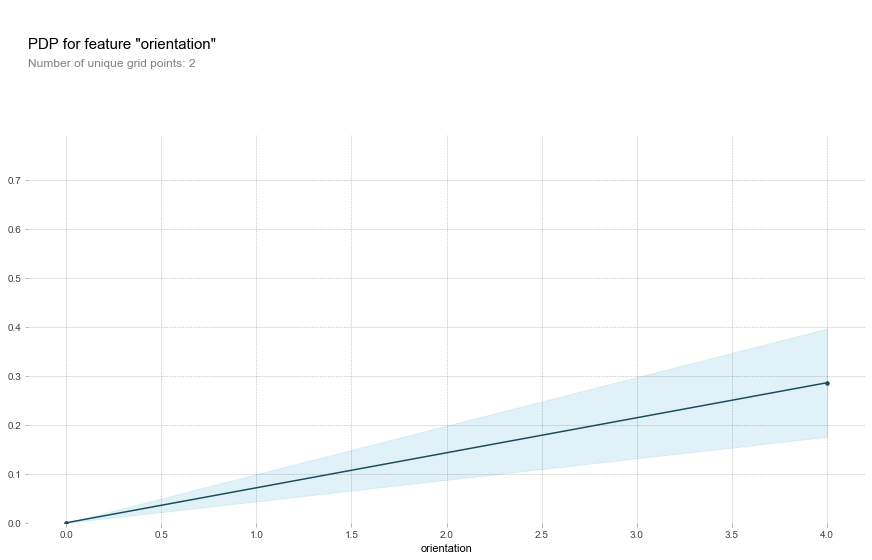

In [39]:
pdp_plot(isolated, feature_name = feature)